# Cython implemented extension

testing the quality of the cython extension used for fast simulation and account valuation

In [1]:
import sustained_ihp_c
import numpy as np
import matplotlib.pyplot as plt

In [2]:
l0 = 1
linf = 0.1
kappa = 0.7
delta10 = 0.02
delta11 = 0.5
delta2 = 1
rho = 0.06
c = 6
params = np.array([l0, linf, kappa, delta10, delta11, delta2, rho, c], dtype=np.float)

In [3]:
balance = 40
npoints = 50
lhatmin = params[1] + params[1] * 0.1
lhatmax = 10
lambda_hats = np.linspace(lhatmin, lhatmax, npoints)
lambda_hats = np.insert(lambda_hats, 0, 0)
sust_costsmc = np.zeros_like(lambda_hats)
jump_costsmc = np.zeros_like(lambda_hats)
collectedmc = np.zeros_like(lambda_hats)
arrivalsmc = np.zeros_like(lambda_hats)
accvalsmc = np.zeros_like(lambda_hats)
acvalsmc_std = np.zeros_like(lambda_hats)

In [14]:
niter = 10000
for i, lhat in enumerate(lambda_hats):
    intermediate_res = np.asarray(sustained_ihp_c.calculate_value_mc_nogil(lhat, niter, balance, params))
    ar = intermediate_res[:, 0]
    collected = intermediate_res[:, 1]
    sust_cost = intermediate_res[:, 2]
    jump_cost = intermediate_res[:, 3]
    accvalsmc[i] = np.mean(sust_cost + jump_cost - collected)
    acvalsmc_std[i] = np.std(sust_cost + jump_cost - collected)
    sust_costsmc[i] = np.mean(sust_cost)
    jump_costsmc[i] = np.mean(jump_cost)
    collectedmc[i] = np.mean(-collected)
    arrivalsmc[i] = np.mean(ar)

In [15]:
np.mean(sust_cost) + np.mean(collected)

43.781131523085634

In [6]:
np.mean(sust_cost + collected)

43.86238196472434

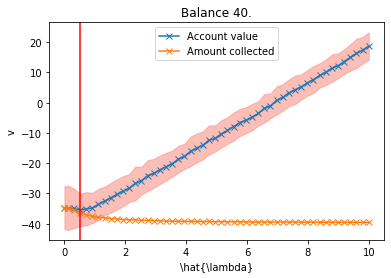

In [7]:
def plot_value(lambda_hats, accvalsmc, collectedmc, balance=0, std=None):
    lhatstar_index = np.nanargmin(accvalsmc)
    lhatstar = lambda_hats[lhatstar_index]
    fig, ax = plt.subplots()
    ax.plot(lambda_hats, accvalsmc, marker='x')
    ax.plot(lambda_hats, collectedmc, marker='x')
    ax.axvline(x=lhatstar, color='r')
    ax.set_xlabel('\hat{\lambda}')
    ax.set_ylabel('v')
    ax.legend(['Account value', 'Amount collected'])
    ax.set_title(f'Balance {balance}.')
    if std is not None:
        ax.fill_between(lambda_hats, accvalsmc, accvalsmc + std, color='salmon', alpha=0.5)
        ax.fill_between(lambda_hats, accvalsmc, accvalsmc - std, color='salmon', alpha=0.5)
    return fig
fig = plot_value(lambda_hats, accvalsmc, collectedmc, balance, acvalsmc_std)

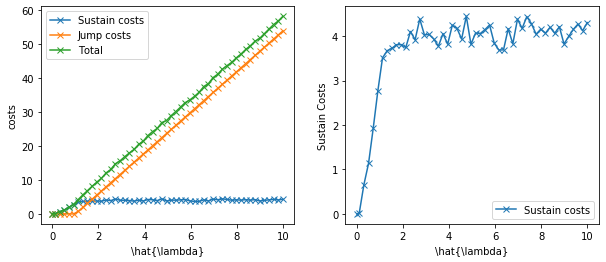

In [8]:
def plot_costs(lambda_hats, sust_costsmc, jump_costsmc):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    ax[0].plot(lambda_hats, sust_costsmc, marker='x')
    ax[0].plot(lambda_hats, jump_costsmc, marker='x')
    ax[0].plot(lambda_hats, sust_costsmc + jump_costsmc, marker='x')
    ax[0].set_xlabel('\hat{\lambda}')
    ax[0].set_ylabel('costs')
    ax[1].plot(lambda_hats, sust_costsmc, marker='x')
    ax[0].legend(['Sustain costs', 'Jump costs', 'Total'])
    ax[1].legend(['Sustain costs'])
    ax[1].set_xlabel('\hat{\lambda}')
    ax[1].set_ylabel('Sustain Costs')
    return fig
fig = plot_costs(lambda_hats, sust_costsmc, jump_costsmc)

0.718421052631579

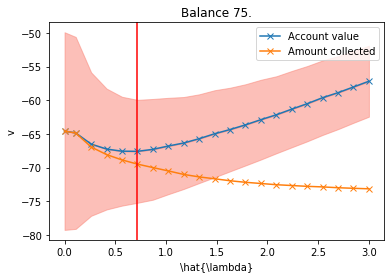

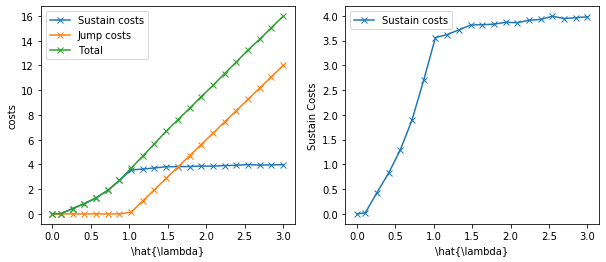

In [9]:
def calculate_profile(balance, lhatmax, npoints, niter, doplots = False):
    lhatmin = params[1] + params[1] * 0.1
    lambda_hats = np.linspace(lhatmin, lhatmax, npoints)
    lambda_hats = np.insert(lambda_hats, 0, 0)
    sust_costsmc = np.zeros_like(lambda_hats)
    jump_costsmc = np.zeros_like(lambda_hats)
    collectedmc = np.zeros_like(lambda_hats)
    arrivalsmc = np.zeros_like(lambda_hats)
    accvalsmc = np.zeros_like(lambda_hats)
    accvalsmc_std = np.zeros_like(lambda_hats)
    for i, lhat in enumerate(lambda_hats):
        intermediate_res = np.asarray(sustained_ihp_c.calculate_value_mc_nogil(lhat, niter, balance, params))
        ar = intermediate_res[:, 0]
        collected = intermediate_res[:, 1]
        sust_cost = intermediate_res[:, 2]
        jump_cost = intermediate_res[:, 3]
        accvalsmc[i] = np.mean(sust_cost + jump_cost - collected)
        accvalsmc_std[i] = np.std(sust_cost + jump_cost - collected)
        sust_costsmc[i] = np.mean(sust_cost)
        jump_costsmc[i] = np.mean(jump_cost)
        collectedmc[i] = np.mean(-collected)
        arrivalsmc[i] = np.mean(ar)
    lhatstar_index = np.nanargmin(accvalsmc)
    lhatstar = lambda_hats[lhatstar_index]
    if doplots:
        plot_value(lambda_hats, accvalsmc, collectedmc, balance, accvalsmc_std)
        plot_costs(lambda_hats, sust_costsmc, jump_costsmc)
    return lhatstar
# test
calculate_profile(75, 3, 20, 100000, True)

In [10]:
def obj_func(lhat):
    niter = 3000000
    balance = 75
    intermediate_res = np.asarray(sustained_ihp_c.calculate_value_mc_nogil(lhat, niter, balance, params))
    ar = intermediate_res[:, 0]
    collected = intermediate_res[:, 1]
    sust_cost = intermediate_res[:, 2]
    jump_cost = intermediate_res[:, 3]
    accvalsmc = np.mean(sust_cost + jump_cost - collected)
    return accvalsmc
obj_func(0.1)

-35.90632441321701

In [42]:
from scipy.optimize import minimize
minimize(obj_func, 0.5)

      fun: -37.26665902023008
 hess_inv: array([[4.33042351e-15]])
      jac: array([381483.90239525])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 71
      nit: 2
     njev: 20
   status: 2
  success: False
        x: array([0.50003097])

In [10]:
# smart division of the w statespace
rmin = 0.1
w0 = 100
np.insert(np.cumprod(np.ones(25) * (1-rmin)) * w0, 0, w0)

array([100.        ,  90.        ,  81.        ,  72.9       ,
        65.61      ,  59.049     ,  53.1441    ,  47.82969   ,
        43.046721  ,  38.7420489 ,  34.86784401,  31.38105961,
        28.24295365,  25.41865828,  22.87679245,  20.58911321,
        18.53020189,  16.6771817 ,  15.00946353,  13.50851718,
        12.15766546,  10.94189891,   9.84770902,   8.86293812,
         7.97664431,   7.17897988])

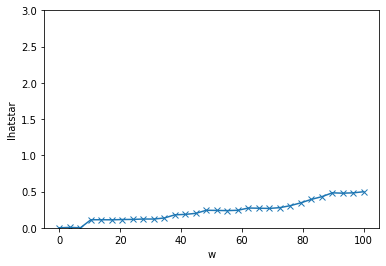

In [22]:
w0 = 100
ws = np.flip(np.linspace(0, w0, 30))
lhatstars = np.zeros_like(ws)
lmax  = 2
npoints = 40
niter = 400000
for i, w in enumerate(ws):
    lhatstars[i] = calculate_profile(w, lmax, npoints, niter)
    lmax = lhatstars[i]+ lhatstars[i] * 0.01
plt.figure()
plt.plot(ws, lhatstars, marker='x')
plt.xlabel('w')
plt.ylabel('lhatstar')
plt.ylim([0.0, 3.0])
plt.show()

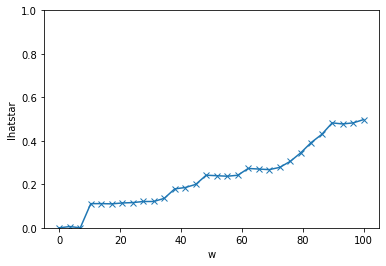

In [23]:
plt.plot(ws, lhatstars, marker='x')
plt.xlabel('w')
plt.ylabel('lhatstar')
plt.ylim([0.0, 1.0])
plt.show()

Parallel processor for each balance

In [12]:
# import multiprocessing as mp
# from functools import partial
# def calc_profile_parallel(w0):
#     niter = 100000
#     lmax = 10
#     npoints = 50
#     n_cpu = mp.cpu_count() - 1
#     ws = np.flip(np.linspace(1, w0, 2))
#     worker = partial(calculate_profile, lmax, npoints, niter)
#     with mp.Pool(n_cpu) as pool:
#         res = pool.map(worker, ws)
#         return ws, res
        
#     #return res
# w, res = calc_profile_parallel(50)      
# res

In [33]:
from multiprocessing import Pool

def f(x):
    return x*x

if __name__ == '__main__':
    with Pool(5) as p:
        print(p.map(f, np.array([1, 2, 3])))

[1, 4, 9]


In [67]:
from functools import partial
lmax = 1
niter = 100000
npoints = 20
worker = partial(calculate_profile, lmax, npoints, niter)

In [68]:
worker(590)

0.11596705967059671

In [ ]:
%timeit worker(50)

### Monte Carlo confirmation of the frontier convexity

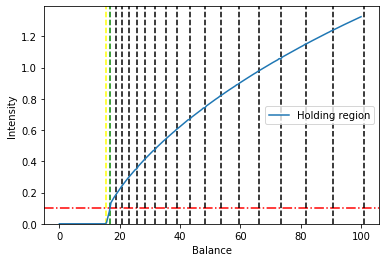

In [73]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))
from dcc import OAV, AAV, Parameters
PATH_TO_PICKLE = '/Users/mmark/Documents/credit_collections/credit_collections_rl/dcc/ref_parameters'
oc = OAV.load(PATH_TO_PICKLE)
fig = oc.plot_statespace()

In [3]:
from sustained_ihp import SustainedIHP
lambda_hat = 0.11
starting_balance = 100
params = Parameters()
sihp = SustainedIHP(starting_balance, params)
sihp.logger.disabled = True

#approx_lstars = sihp.calculate_frontier()
mc = [sihp.calculate_frontier() for i in range(100)]

[INFO] [2020-03-30 15:07:26,461] [SustainedIHP] - Instantiated sustain process @ SustainedIHP


KeyboardInterrupt: 

In [4]:
# parallel version of the previous
from joblib import Parallel, delayed
lambda_hat = 0.11
starting_balance = 100
params = Parameters()
sihp = SustainedIHP(starting_balance, params)
sihp.logger.disabled = True

#approx_lstars = sihp.calculate_frontier()
# Parallel(n_jobs=1)(delayed(sqrt)(i**2) for i in range(10))
mc = Parallel(n_jobs=10)(delayed(sihp.calculate_frontier)() for i in range(100))

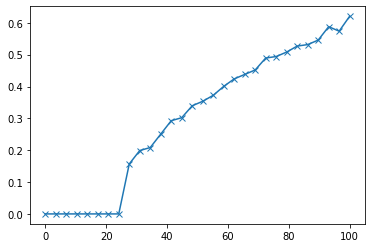

In [5]:
plt.figure(fig.number)
plt.plot(sihp.ws, np.mean(np.array(mc),0),marker='x')

In [6]:
new_plot = fig.add_subplot()
new_plot.plot(sihp.ws, np.mean(np.array(mc),0),marker='x')

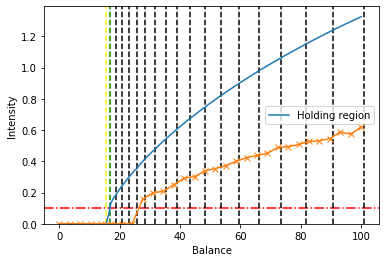

In [7]:
fig, ax = plt.subplots()
ax.axhline(y=oc.p.lambdainf, linestyle='-.', color='red')
ax.axvline(x=oc.w_, linestyle='--', color='yellow')
ax.axvline(x=oc.w0star, linestyle='--', color='green')
for wstar in oc.wistar[2:]:
    ax.axvline(x=wstar, linestyle='--', color='black')

h1 = ax.plot(oc.w_vector, oc.lambdastars)
ax.set_ylim(bottom=0)
ax.set_xlabel('Balance')
ax.set_ylabel('Intensity')
ax.legend([h1[0]], ['Holding region'])
ax.plot(sihp.ws, np.mean(np.array(mc),0),marker='x')

In [87]:
def optimal_frontier(w):
    index = np.digitize(w, oc.w_vector)
    return oc.lambdastars[index]

In [86]:
oc.w_vector[10]

5.025125628140703

In [99]:
from chp import CHP
def control(w):
    shift = 50
    if isinstance(w, np.ndarray):
        return (0.001 * (w - shift)).clip(min=0)
    elif np.isscalar(w):
        return np.maximum(0.001 * (w - shift), 0)
    else:
        raise ValueError('Stupid error in w.')
        
chp = CHP(starting_balance=75, starting_intensity=1, marginal_cost=6,
              collection_horizon=100, lambda_infty=0.1, kappa=1, value_precision_thershold=0.0,
              delta10=0.05, delta11=0.5, control_function=optimal_frontier, rho=0.05)

[INFO] [2020-03-31 16:18:03,511] [CHP] - Instantiated Controlled Hawkes Process @ 


-55.12931848476602


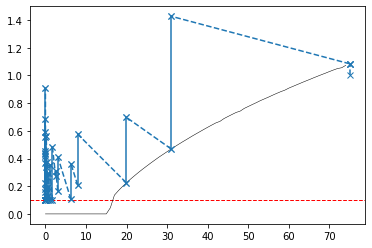

/Users/mmark/Documents/credit_collections/credit_collections_rl/chp.py:185: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/mmark/Documents/credit_collections/credit_collections_rl/chp.py:249: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/mmark/Documents/credit_collections/credit_collections_rl/chp.py:260: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


NameError: name 'chp' is not defined

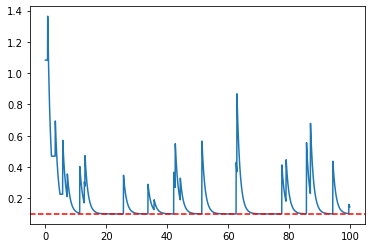

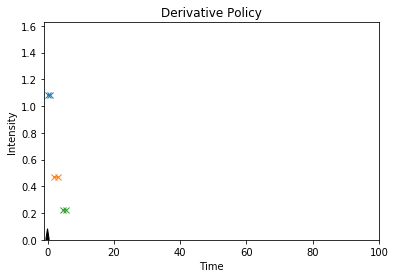

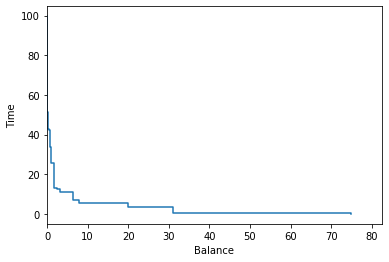

In [100]:
print(chp.calculate_value_single())
chp.plot_statespace()
chp.plot_intensity()
chp.plot_policy()
chp.plot_balance()
chp.test_increments()